In [1]:
import os
import numpy as np

import torch as th
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
# from safetensors.torch import save_model, load_model

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import trange

from typing import List, Union, Callable, Tuple
from torch import Tensor

# Set the default style
sns.set_theme(
	style="whitegrid",
	palette="tab10",
	rc={
		"grid.linestyle": "--",
		"grid.color": "gray",
		"grid.alpha": 0.3,
		"grid.linewidth": 0.3,
	},
)

# # Constant hyperparameters
TRAIN_BS: int = 250	# Batch size for training
# TEST_BS: int = 1024	# Batch size for testing
EPOCHS: int = 10	# Number of epochs

# Hyperparameters
DEVICE_AUTODETECT: bool = True
# TRAIN_BATCH_SIZE: int = 64
# TEST_BATCH_SIZE: int = 1000
# EPOCHS: int = 15
CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="mean")
)
EVAL_CRITERION: Union[th.nn.Module, Callable[[th.Tensor], th.Tensor]] = (
    th.nn.CrossEntropyLoss(reduction="sum")
)
LR: float = 2e-3


In [2]:
# Define the transformations for the training and testing datasets
transform = transforms.Compose([
    # transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
])

# Define the paths to the training and testing datasets
train_dir = 'datasets/cleaned/Training'
test_dir = 'datasets/cleaned/Testing'

# Create the datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=TRAIN_BS, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=TEST_BS, shuffle=False)

# Example of iterating through the DataLoader
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([250, 3, 256, 256]) torch.Size([250])


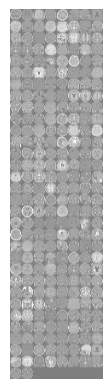

0 2 2 3 1 3 3 2 2 3 2 2 2 2 3 1 0 1 0 0 2 2 2 2 2 2 1 2 2 0 1 3 3 1 0 2 2 1 0 0 3 3 2 3 2 3 0 2 2 0 3 0 0 1 1 3 3 1 1 0 3 2 2 2 1 1 0 2 0 0 0 3 0 3 0 2 1 2 0 2 0 3 2 1 1 2 1 2 2 1 2 3 1 2 3 3 0 0 2 0 1 0 0 2 1 2 2 3 2 1 3 0 2 3 2 1 0 0 1 2 0 2 3 2 3 0 3 1 0 3 1 0 1 1 0 1 0 2 2 3 2 0 3 0 2 3 0 0 1 0 2 0 2 3 0 0 2 3 1 2 2 2 3 0 1 3 1 0 0 2 1 1 0 1 0 2 2 2 3 2 1 2 3 2 2 1 3 0 0 2 1 1 3 1 3 2 3 2 2 3 1 2 2 1 0 2 2 0 2 2 0 0 0 0 2 0 1 1 1 3 3 2 1 0 2 3 0 0 0 0 2 2 1 0 1 1 0 3 2 2 1 2 0 2 3 3 2 3 3 1


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

# Print labels
print(' '.join(f'{labels[j]}' for j in range(len(labels))))

In [4]:
class MyCNN(th.nn.Module):
    def __init__(self, cls_out: int = 10) -> None:
        super().__init__()

        self.conv = th.nn.Sequential(
            th.nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=23, stride=1, padding=0
            ),
            th.nn.Mish(),
            th.nn.MaxPool2d(kernel_size=2),
            th.nn.Dropout(p=0.2),
            th.nn.Conv2d(
                in_channels=16, out_channels=8, kernel_size=23, stride=2, padding=1
            ),
            th.nn.Mish(),
            th.nn.MaxPool2d(kernel_size=2, stride=1),
            th.nn.Flatten(),
        )

        self.head = th.nn.Linear(18432, cls_out)

    def forward(self, x: Tensor) -> Tensor:
        return self.head(self.conv(x))

In [5]:
model: MyCNN = MyCNN()
model.train()

MyCNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(23, 23), stride=(1, 1))
    (1): Mish()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.2, inplace=False)
    (4): Conv2d(16, 8, kernel_size=(23, 23), stride=(2, 2), padding=(1, 1))
    (5): Mish()
    (6): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (head): Linear(in_features=18432, out_features=10, bias=True)
)

In [6]:
# Let's define the optimizer
optimizer: th.optim.Optimizer = th.optim.Adam(
    params=model.parameters(), lr=LR, weight_decay=0
)

In [7]:
eval_losses: List[float] = []
eval_acc: List[float] = []
test_acc: List[float] = []

# Loop over epochs
for epoch in trange(EPOCHS, desc="Training epoch"):

    model.train()  # Remember to set the model in training mode before actual training

    # Loop over data
    for batch_idx, batched_datapoint in enumerate(train_loader):

        x, y = batched_datapoint

        # Forward pass + loss computation
        yhat = model(x)
        loss = CRITERION(yhat, y)

        # Zero-out past gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update model parameters
        optimizer.step()

    # Log the loss and accuracy on the training set...
    num_elem: int = 0
    trackingmetric: float = 0
    trackingcorrect: int = 0

    model.eval()  # Remember to set the model in evaluation mode before evaluating it

    # Since we are just evaluating the model, we don't need to compute gradients
    with th.no_grad():
        # ... by looping over training data again
        for _, batched_datapoint_e in enumerate(train_loader):
            x_e, y_e = batched_datapoint_e
            modeltarget_e = model(x_e)
            ypred_e = th.argmax(modeltarget_e, dim=1, keepdim=True)
            trackingmetric += EVAL_CRITERION(modeltarget_e, y_e).item()
            trackingcorrect += ypred_e.eq(y_e.view_as(ypred_e)).sum().item()
            num_elem += x_e.shape[0]
        eval_losses.append(trackingmetric / num_elem)
        eval_acc.append(trackingcorrect / num_elem)


Training epoch:   0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
loss_color = "tab:red"
acc_color = "tab:blue"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss", color=loss_color)
ax1.plot(eval_losses, color=loss_color)
ax1.tick_params(axis="y", labelcolor=loss_color)

ax2 = ax1.twinx()
ax2.set_ylabel("Accuracy", color=acc_color)
ax2.plot(eval_acc, color=acc_color)
ax2.tick_params(axis="y", labelcolor=acc_color)

fig.tight_layout()

plt.title("Training loss and accuracy")
plt.show()

In [ ]:
print(f"Final training loss: {eval_losses[-1]}")
print(f"Final training accuracy: {eval_acc[-1]}")